# Скоринговая модель (лог-рег), тестовое
## Гиро Елизавета

Необходимо было построить скоринговую модель с помощью логистической регрессии на заданном наборе данных.

<span style="color:#008B8B">Синим цветом будут помечены идеи для улучшения текущего решения.</span>

In [1]:
# imports
import pandas as pd
import numpy as np
from scipy.stats import stats
import matplotlib.pyplot as plt
import operator
import optbinning
from feature_engine.selection import DropHighPSIFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

(CVXPY) May 09 01:57:58 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 09 01:57:58 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# variables
data_file = 'data/data_with_nb.xlsx'
data_sheet = 'Выборка'

woe_numeric_file = 'output/woe_numeric_tables.xlsx'
woe_category_file = 'output/woe_category_tables.xlsx'

output_result_file = 'output/results.xlsx'

In [3]:
random_state=357

In [4]:
def get_df_stat(df):
    df_stat = pd.DataFrame(data = [], index=df.columns)
    df_stat['nunique'] = df.nunique()
    df_stat['na_percent'] = df.isna().sum() * 100 / len(df)
    df_stat['type'] = df.dtypes
    return df_stat

### Предобработка данных

Сначала прочитаем данные и удалим дубликаты в колонках (дублирующих строк не было).

In [5]:
df = pd.read_excel(data_file, sheet_name=data_sheet)
df.head()

,def,ID pers,ID,ID loan,п1,п2,п3,п4,п5,п6,...,п58,п59,п60,п61,п62,п63,п64,п65,п66,п67
0,0,173359,53.040121.002,53-050121-1-1,Престиж,Нет,Нет,24.9,5500,5500,...,Нет,Нет,Нет,NaN,Да,Да,5500,Нет,Да,9.0
1,0,0972QL,55.040121.001,55-040121-1-1,Классик,Нет,Да,24.9,3100,3100,...,Нет,Нет,Нет,NaN,Да,Да,3100,Нет,Да,11.0
2,0,496068,84.040121.001,84-040121-1-1,Престиж,Нет,NaN,24.9,1500,1200,...,Нет,Нет,Нет,NaN,Да,Да,1200,Нет,Да,19.0
3,0,091AVO,01.050121.001,50-110121-1-1,Престиж,Да,Нет,24.9,9000,9000,...,Нет,Нет,Нет,Да,Да,Да,9000,Нет,Да,65.0
4,0,0973AK,54.050121.002,54-050121-1-1,Классик,Нет,Да,24.9,3000,2800,...,Нет,Нет,Нет,NaN,Да,Да,2800,Нет,Да,177.0


In [6]:
# drop duplicate columns
df = df.loc[:,~df.T.duplicated(keep='first')]

Соберем информацию о датасете и удалим ненужные данные.

* Колонки с 1 единственным уникальным значением бесполезны.
* Колонки с более 80% пропусков тоже.
* Также из-за зашифрованности данных и невозможности отранговать категориальные колонки с большим количество уникальных значений, придется их тоже удалить.
* Колонки со ставкой и сроком кредита удаляем, потому что такие показатели нестабильны во времени и могут потерять свою актуальность.

<span style="color:#008B8B">Если в данных остались бы названия кредитных продуктов или что-то связанное с конкретным типом кредита, то такие данные тоже стоит удалить. Проверить это можно только на незакодированных данных. Также некоторые признаки могут быть удалены экспертно.</span>

In [7]:
df_stat = get_df_stat(df)
df_stat

,nunique,na_percent,type
def,2,0.000000,int64
ID pers,9433,0.019153,object
ID,10442,0.000000,object
ID loan,10432,0.095767,object
п1,6,0.000000,object
...,...,...,...
п62,2,0.000000,object
п63,2,0.000000,object
п65,2,0.000000,object
п66,2,0.000000,object


In [8]:
df = df.drop(df_stat[(df_stat['nunique'] == 1) | (df_stat['na_percent'] > 80)].index, axis=1)
df = df.drop(df_stat[(df_stat['nunique'] > 10) & (df_stat['type'] == 'object')].index, axis=1)

In [9]:
useless_columns_list = ['п4', 'п51', 'п7', 'п8']
df = df.drop(useless_columns_list, axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10442 entries, 0 to 10441
Data columns (total 53 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   def     10442 non-null  int64         
 1   п1      10442 non-null  object        
 2   п2      10442 non-null  object        
 3   п3      10439 non-null  object        
 4   п5      10442 non-null  int64         
 5   п6      10442 non-null  int64         
 6   п9      10442 non-null  int64         
 7   п10     10442 non-null  int64         
 8   п12     10441 non-null  object        
 9   п13     10442 non-null  int64         
 10  п14     10442 non-null  object        
 11  п15     10442 non-null  object        
 12  п16     10442 non-null  int64         
 13  п17     10442 non-null  int64         
 14  п18     10442 non-null  int64         
 15  п19     10442 non-null  object        
 16  п20     10365 non-null  object        
 17  п21     10442 non-null  object        
 18  п22   

In [11]:
df = df.replace('Да', 1)
df = df.replace('Нет', 0)

In [12]:
df_numerical_features = df.select_dtypes(include='number').columns
df_numerical_features

Index(['def', 'п2', 'п3', 'п5', 'п6', 'п9', 'п10', 'п13', 'п16', 'п17', 'п18',
       'п22', 'п24', 'п25', 'п26', 'п27', 'п28', 'п29', 'п31', 'п34', 'п35',
       'п36', 'п38', 'п39', 'п40', 'п41', 'п42', 'п46', 'п48', 'п50', 'п54',
       'п55', 'п56', 'п57', 'п58', 'п59', 'п60', 'п61', 'п62', 'п63', 'п65',
       'п66', 'п67'],
      dtype='object')

### PSI

Сделала простую проверку на psi, разделив выборку на 2 части по времени. Существенных перекосов нет, но на пункт 5 и 39 я бы обратила внимание. И уже отталкивалась бы от физического смысла переменной.

In [13]:
transformer = DropHighPSIFeatures(
   cut_off = pd.to_datetime('2022.01.01'), # the cut_off date
   split_col='п43', # the date variable
   strategy = 'equal_frequency',
   bins=5,
   threshold=0.2,
   missing_values='ignore'
)

In [14]:
transformer.fit(df)
transformer.psi_values_

{'def': 0.0,
 'п2': 0.0,
 'п3': 0.0,
 'п5': 0.14463501196646214,
 'п6': 0.11543139764419919,
 'п9': 0.004129043143522559,
 'п10': 0.0,
 'п13': 0.0,
 'п16': 0.004811541876441274,
 'п17': 0.004080111181347607,
 'п18': 0.0,
 'п22': 0.012023608637280697,
 'п24': 0.0,
 'п25': 0.0,
 'п26': 0.0,
 'п27': 0.0,
 'п28': 0.04450632927294812,
 'п29': 0.05446996445074312,
 'п31': 0.030993318437098467,
 'п34': 0.12756058363859563,
 'п35': 0.0036083250807044677,
 'п36': 0.1302521259953678,
 'п38': 0.1232600561953609,
 'п39': 0.15750110858543917,
 'п40': 0.10315638964860635,
 'п41': 0.0,
 'п42': 0.006997968765430208,
 'п46': 0.024289016704891964,
 'п48': 0.0,
 'п50': 0.0,
 'п54': 0.0,
 'п55': 0.0,
 'п56': 0.0,
 'п57': 0.0,
 'п58': 0.0,
 'п59': 0.0,
 'п60': 0.0,
 'п61': 0.0,
 'п62': 0.0,
 'п63': 0.0,
 'п65': 0.0,
 'п66': 0.0,
 'п67': 0.011154843059316027}

In [15]:
transformer.features_to_drop_

[]

Отделяем тестовую часть от выборки, в нее больше не смотрим до финального варианта модели.
Отделяем в одинаковом процентном соотношении дефолта.

In [16]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=random_state, stratify=df['def'])

In [17]:
df_train_stat = get_df_stat(df_train)
df_train_stat

,nunique,na_percent,type
def,2,0.000000,int64
п1,6,0.000000,object
п2,2,0.000000,int64
п3,2,0.038309,float64
п5,877,0.000000,int64
п6,738,0.000000,int64
п9,47,0.000000,int64
п10,2,0.000000,int64
п12,8,0.000000,object
п13,3,0.000000,int64


В переменных, у которых процент пропусков больше 20, оставляем пропуски для отдельного бина. В остальных переменных заменяем модой для качественных или медианой для количественных, так как она более устойчива к выборке.

<span style="color:#008B8B">Также отталкиваясь от смысла переменной можно натренировать простые модельки, которые бы заполнили пропуски.</span>

In [18]:
nan_replace_list = df_train_stat[(df_train_stat['na_percent'] > 0) & (df_train_stat['na_percent'] < 20)].index.values
nan_replace_list

array(['п3', 'п20', 'п34', 'п37', 'п48', 'п50', 'п67'], dtype=object)

In [19]:
for feature in nan_replace_list:
   if df_train[feature].dtype == object:
       df_train[feature] = df_train[feature].fillna(df_train[feature].mode().values[0])
       df_test[feature] = df_test[feature].fillna(df_train[feature].mode().values[0])
   else:
       df_train[feature].fillna(df_train[feature].median(), inplace=True)
       df_test[feature].fillna(df_train[feature].median(), inplace=True)

In [20]:
df_train_stat = get_df_stat(df_train)
df_train_stat

,nunique,na_percent,type
def,2,0.000000,int64
п1,6,0.000000,object
п2,2,0.000000,int64
п3,2,0.000000,float64
п5,877,0.000000,int64
п6,738,0.000000,int64
п9,47,0.000000,int64
п10,2,0.000000,int64
п12,8,0.000000,object
п13,3,0.000000,int64


In [21]:
features_to_category_list = df_train_stat[(df_train_stat['nunique'] == 2) & (df_train_stat['type'] != object)].drop('def').index.values
features_to_category_list

array(['п2', 'п3', 'п10', 'п24', 'п25', 'п26', 'п41', 'п48', 'п50', 'п54',
       'п55', 'п56', 'п57', 'п58', 'п59', 'п60', 'п61', 'п62', 'п63',
       'п65', 'п66'], dtype=object)

In [22]:
df_train[features_to_category_list] = df_train[features_to_category_list].astype('category')
df_test[features_to_category_list] = df_test[features_to_category_list].astype('category')

In [23]:
df_train_stat = get_df_stat(df_train)
df_train_stat

,nunique,na_percent,type
def,2,0.000000,int64
п1,6,0.000000,object
п2,2,0.000000,category
п3,2,0.000000,category
п5,877,0.000000,int64
п6,738,0.000000,int64
п9,47,0.000000,int64
п10,2,0.000000,category
п12,8,0.000000,object
п13,3,0.000000,int64


<span style="color:#008B8B">Если бы данные были расшифрованы, то можно было нагенерировать новых признаков более устойчивых ко времени (в относительных величинах).
Можно рассчитать пдн, выделить областные города в отдельную категорию, определить оператора по коду, отранжировать отрасли занятости.</span>

### WOE-преобразование

Я выбрала для разделения на бины готовую библиотеку и настроила следующие параметры:
* максимальное кол-во бинов для переменных 5
* метод деления - квантилями
* минимальный размер бина - 5%
* обязательно наличие монотонновозрастающей/убывающей зависимости

<span style="color:#008B8B">Также можно использовать дерево решений для определения наилучших границ бинов
Для каждой переменной можно также настраивать свои параметры исходя из ее физического смысла.
Также важно смотреть на соответствие логического знака переменной и тренда возрастания или убывания woe.</span>

In [24]:
categorical_features = df_train.drop('def', axis=1).select_dtypes(include=['object', 'category']).columns.values
numeric_features = df_train.drop('def', axis=1).select_dtypes(include=['int64', 'float64']).columns.values

In [25]:
max_n_prebins = 50
max_n_bins = 5
prebinning_method = 'quantile'
min_bin_size = 0.05
monotonic_trend = 'auto_asc_desc'

In [26]:
df_train_woe = pd.DataFrame(index=df_train.drop('п43', axis=1).index, columns=df_train.drop('п43', axis=1).columns)
df_test_woe = pd.DataFrame(index=df_test.drop('п43', axis=1).index, columns=df_test.drop('п43', axis=1).columns)
df_train_woe['def'] = df_train['def']
df_test_woe['def'] = df_test['def']

iv_dict = {}
woe_dict = {}

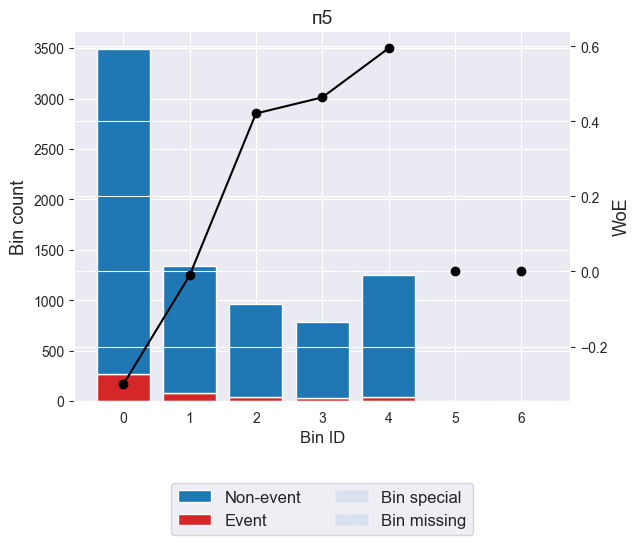

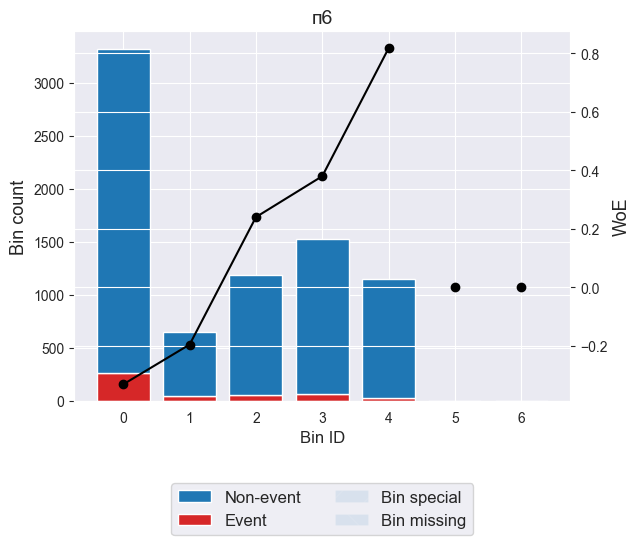

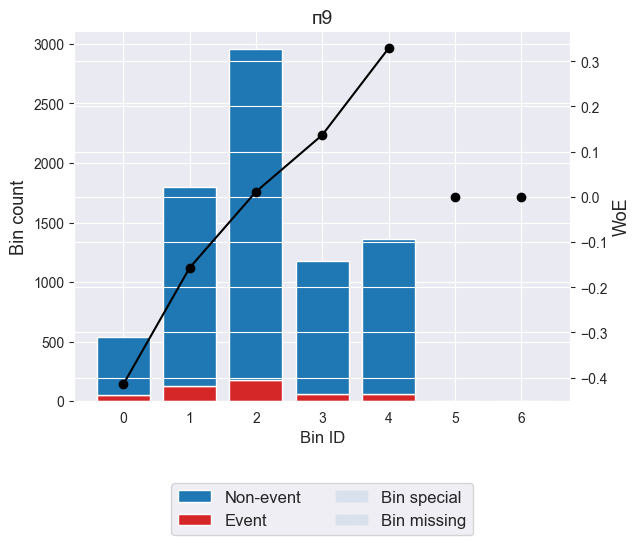

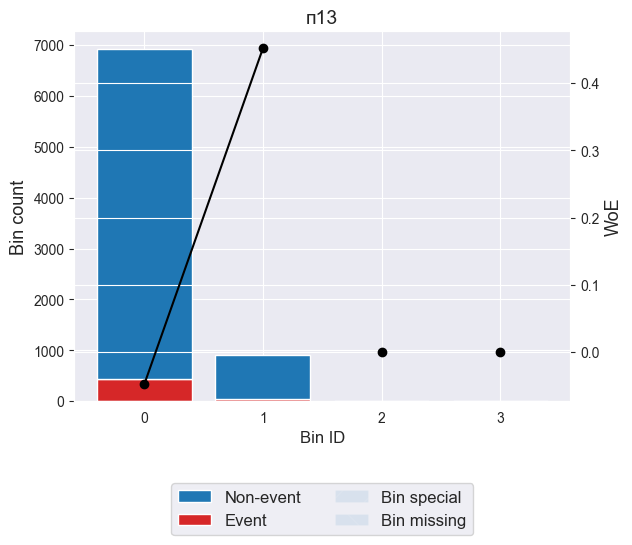

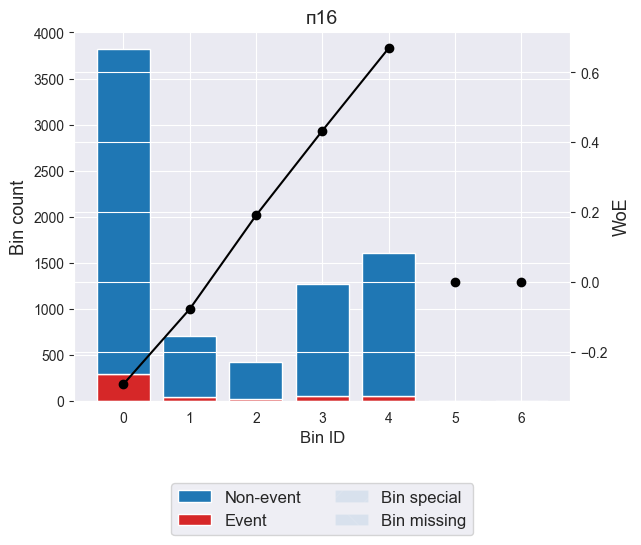

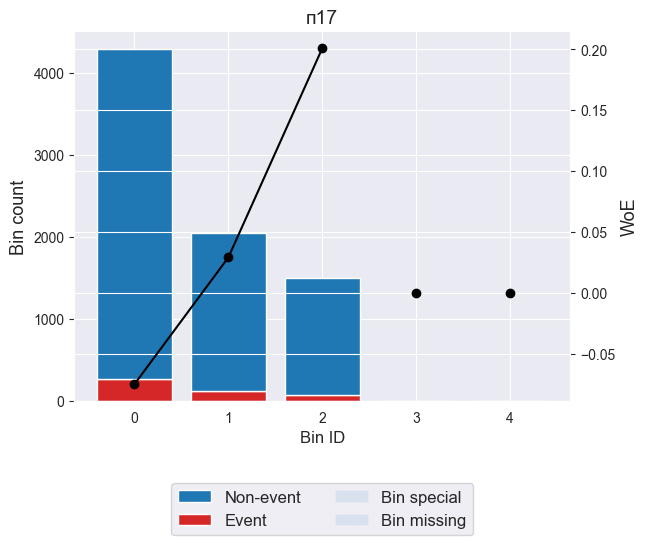

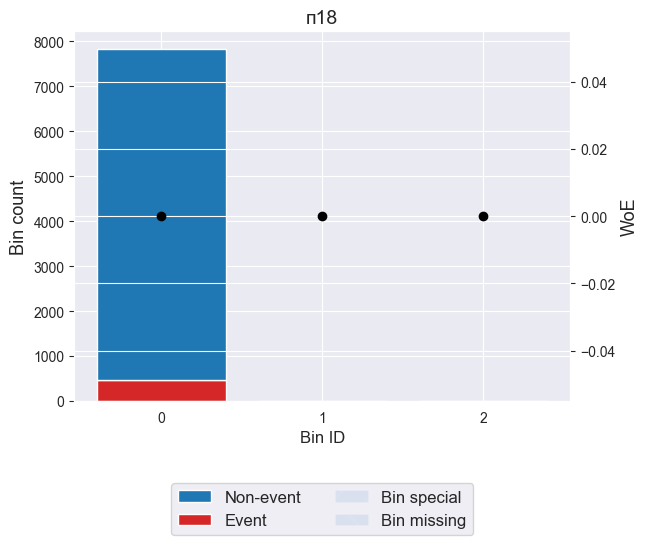

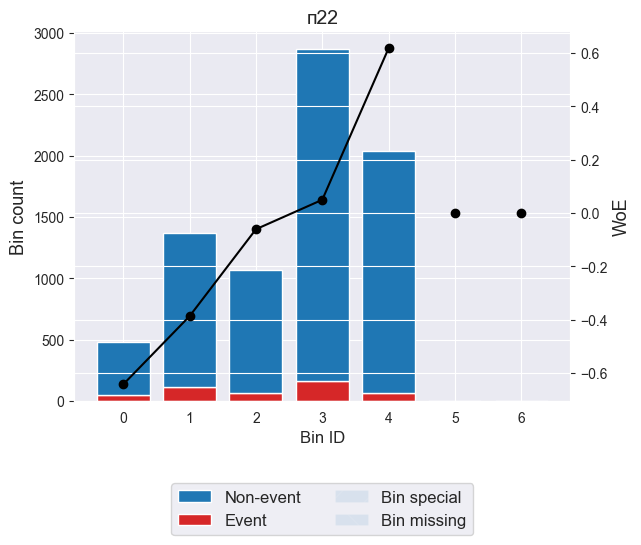

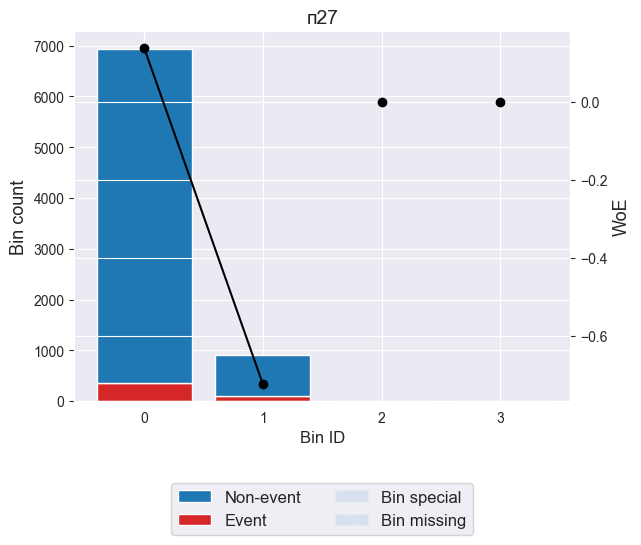

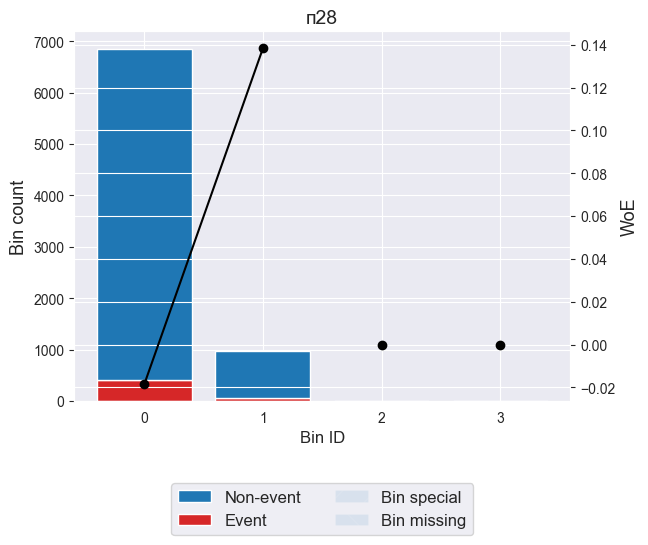

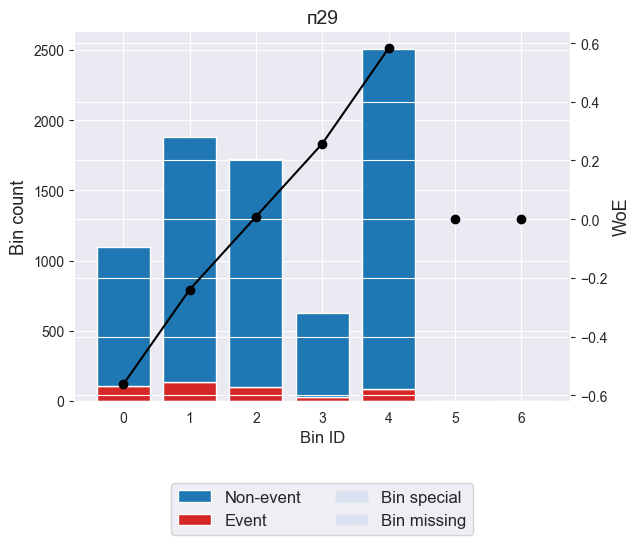

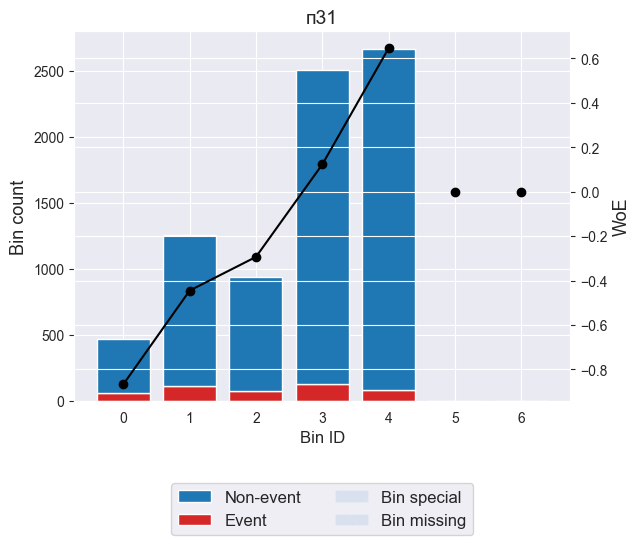

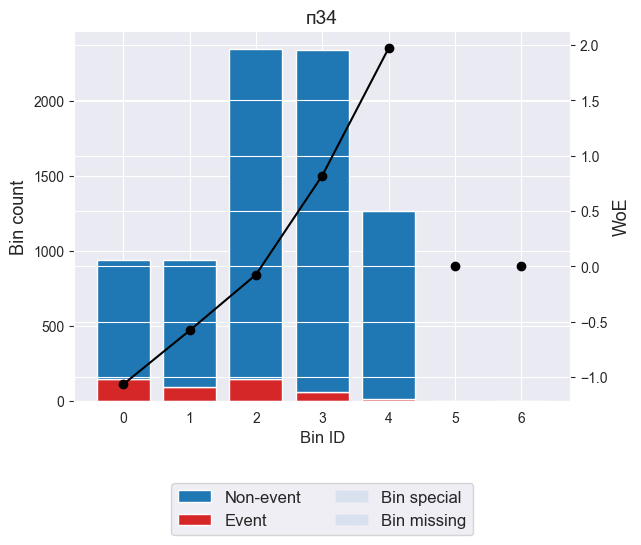

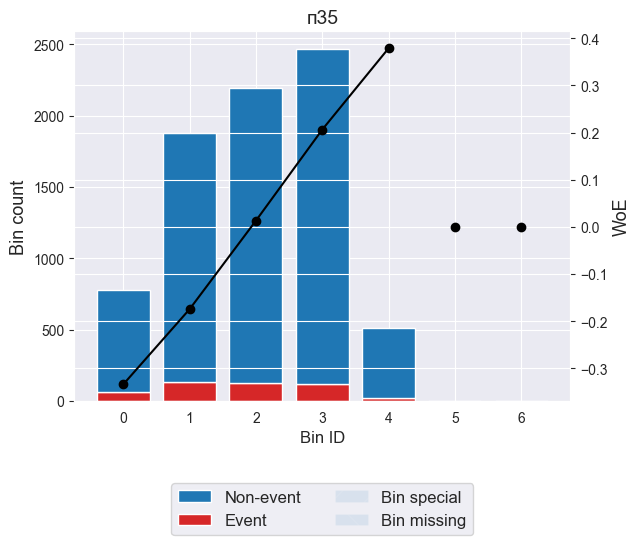

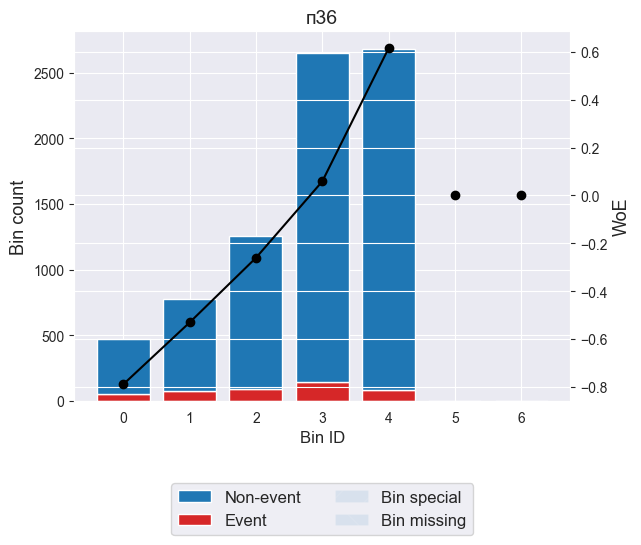

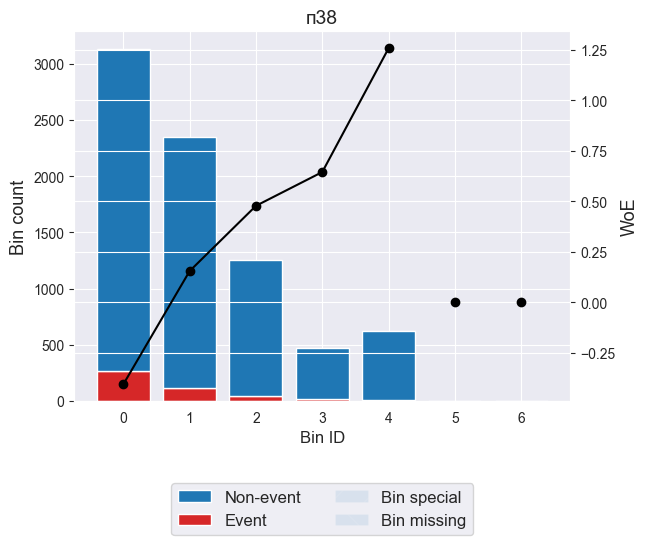

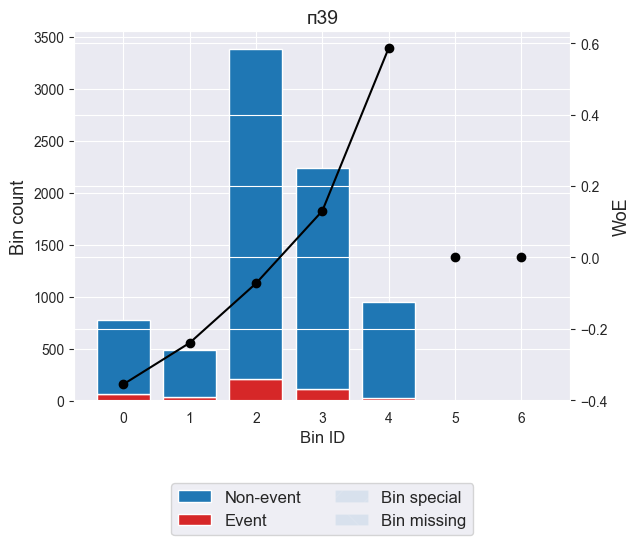

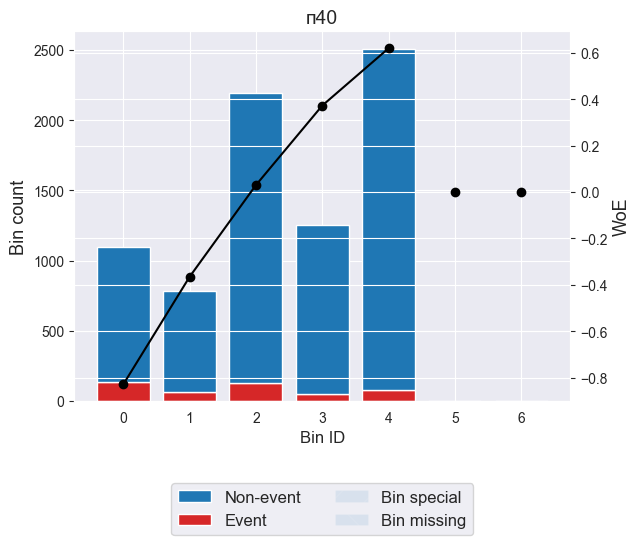

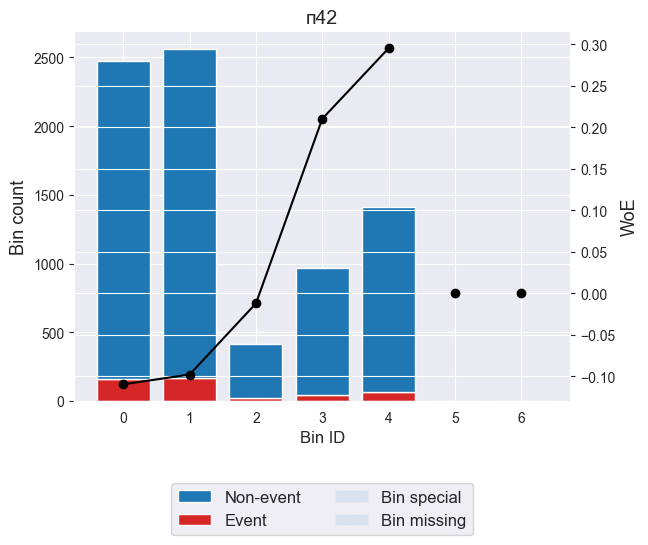

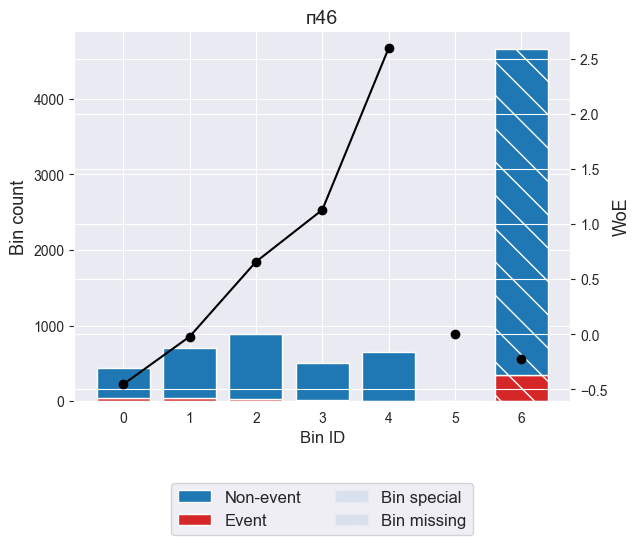

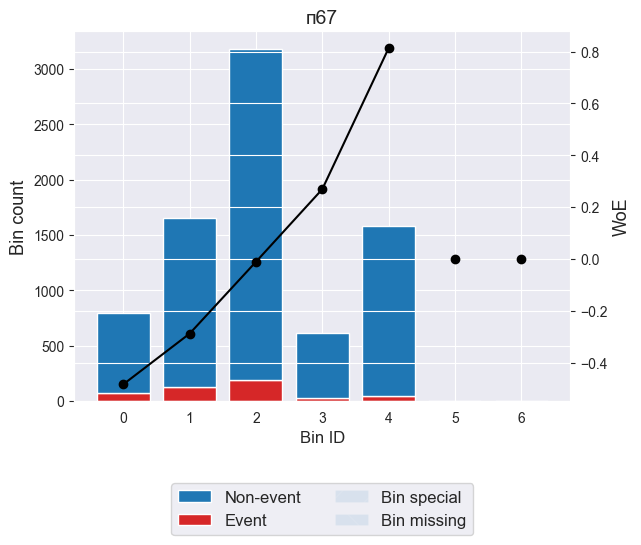

In [27]:
# я вынесла таблицы значений woe всех факторов в отдельный файл, чтобы не загромождать output
writer = pd.ExcelWriter(woe_numeric_file, engine='openpyxl')

for feature in numeric_features:
    optb = optbinning.OptimalBinning(name=feature, dtype='numerical',
                                     prebinning_method=prebinning_method,
                                     max_n_bins=max_n_bins,
                                     max_n_prebins=max_n_prebins,
                                     min_bin_size=min_bin_size,
                                     monotonic_trend=monotonic_trend)
    optb.fit(df_train[feature], df_train['def'])
    df_train_woe[feature] = optb.transform(df_train[feature], metric_missing='empirical')
    df_test_woe[feature] = optb.transform(df_test[feature], metric_missing='empirical')
    woe_dict[feature] = optb.binning_table.build()
    iv_dict[feature] = woe_dict.get(feature).loc['Totals', 'IV']
    optb.binning_table.plot(metric="woe")

    optb.binning_table.build().to_excel(writer, sheet_name=feature)

writer.close()

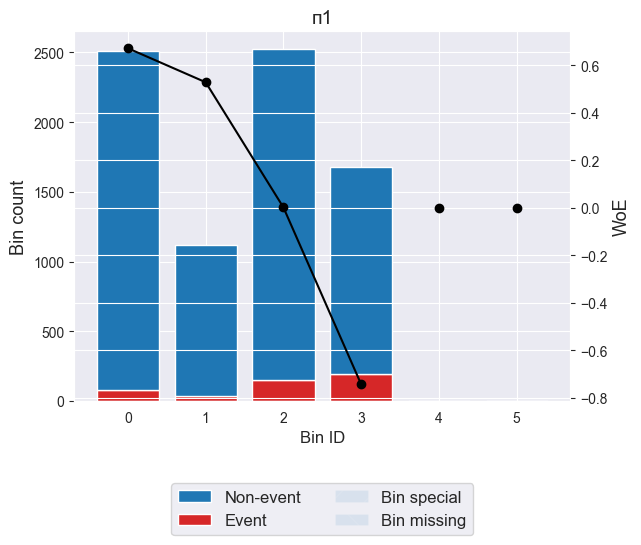

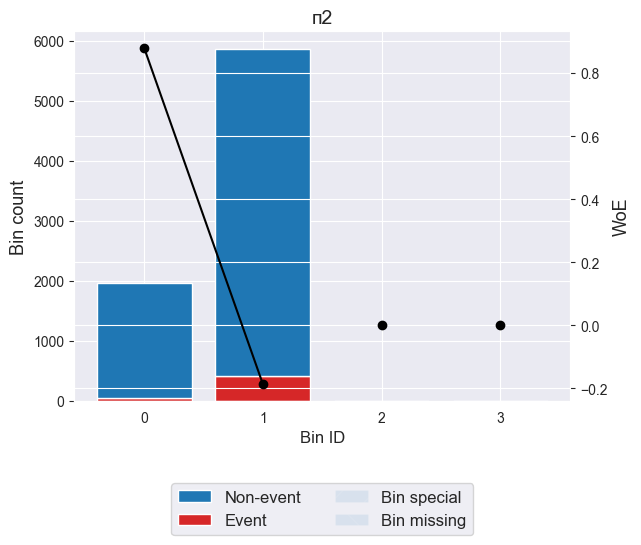

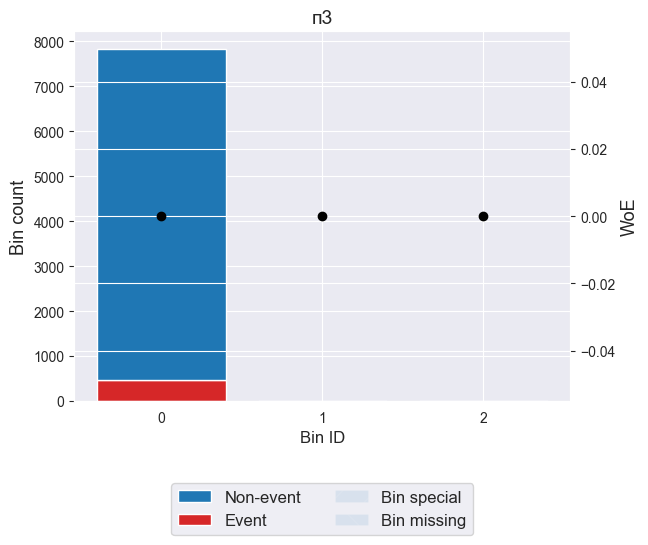

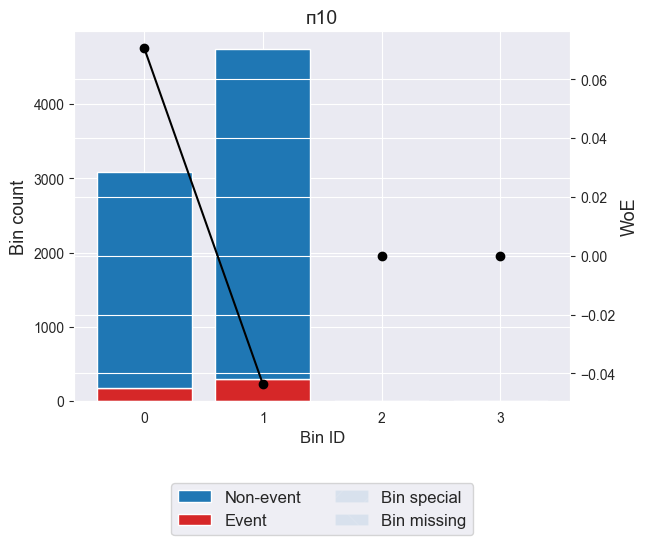

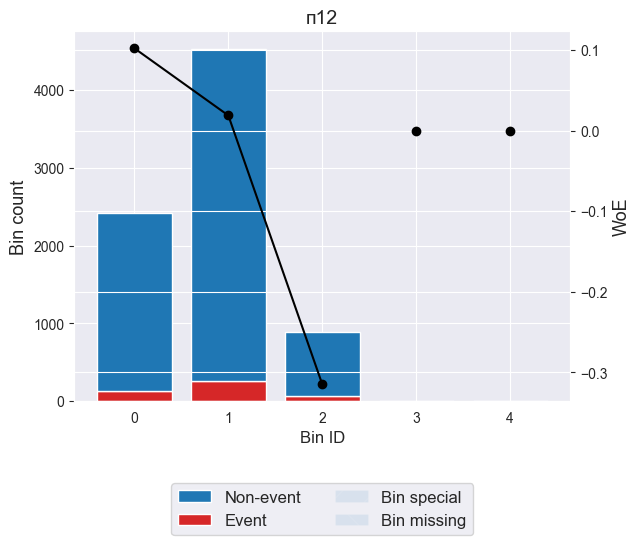

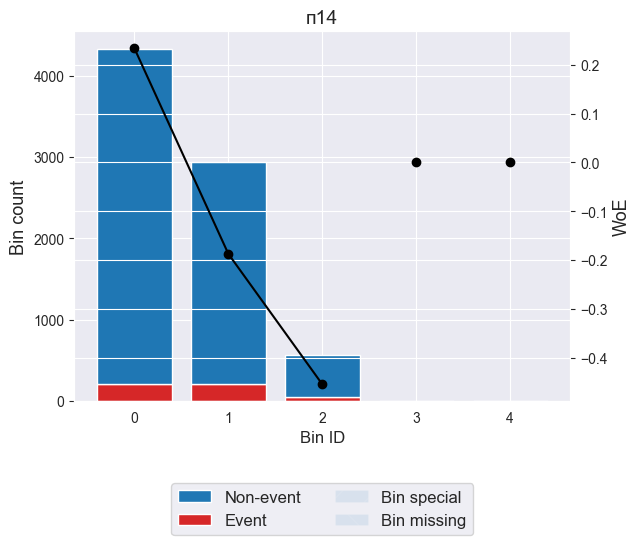

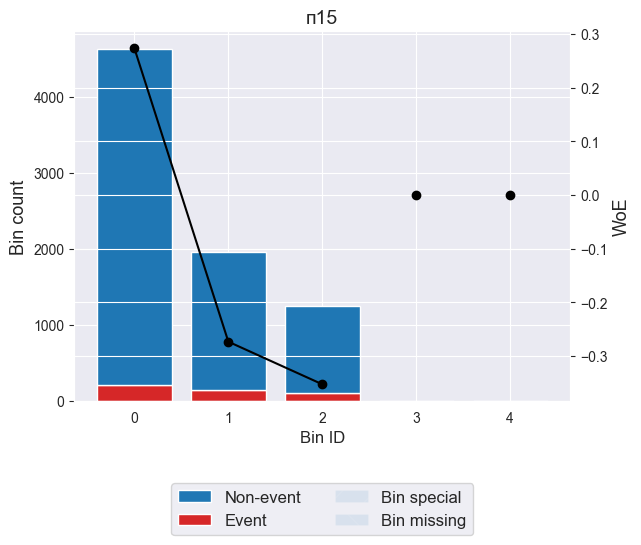

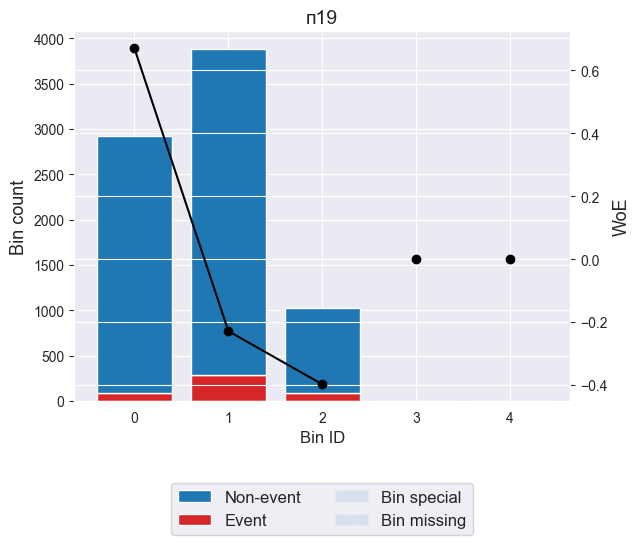

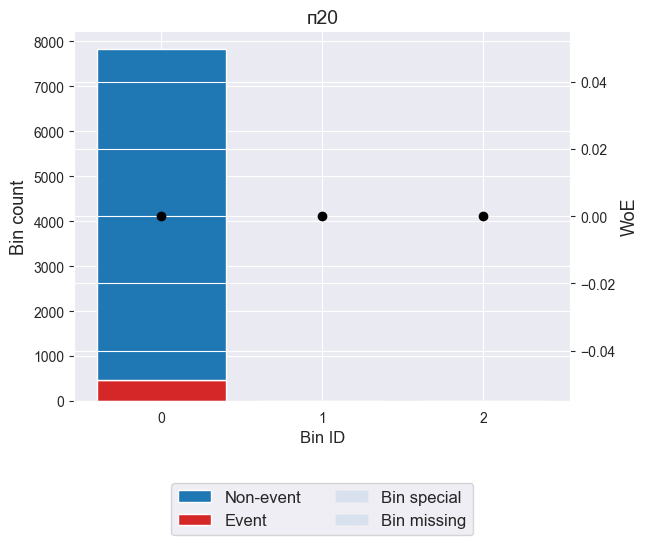

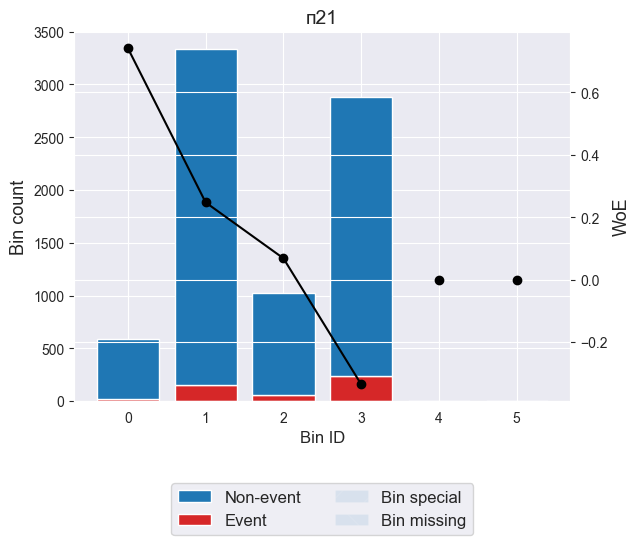

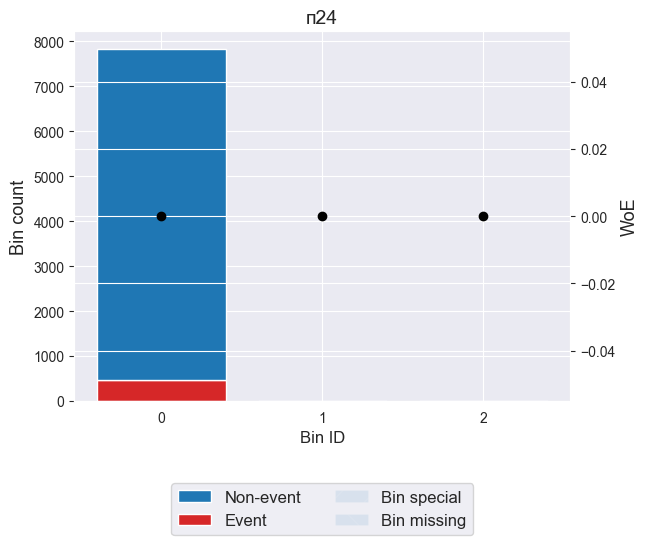

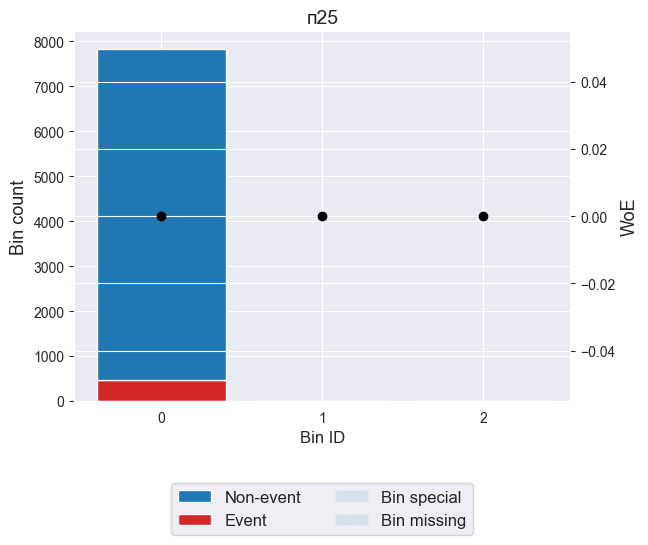

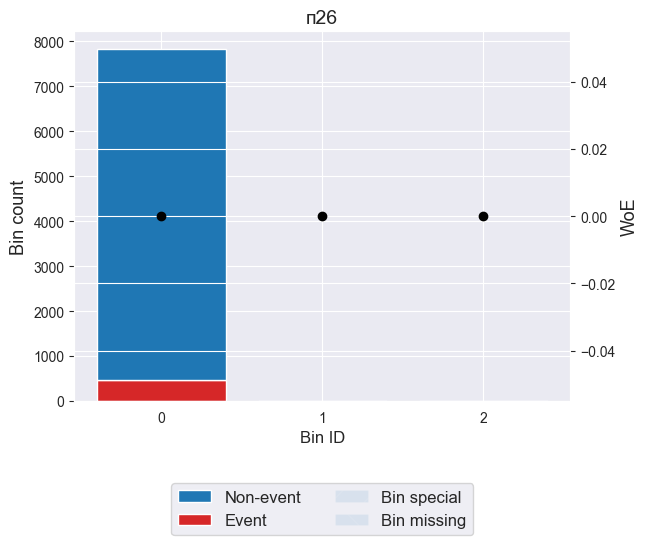

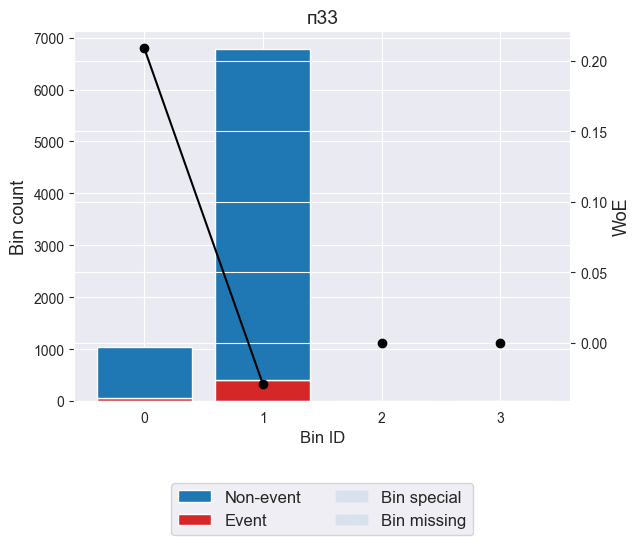

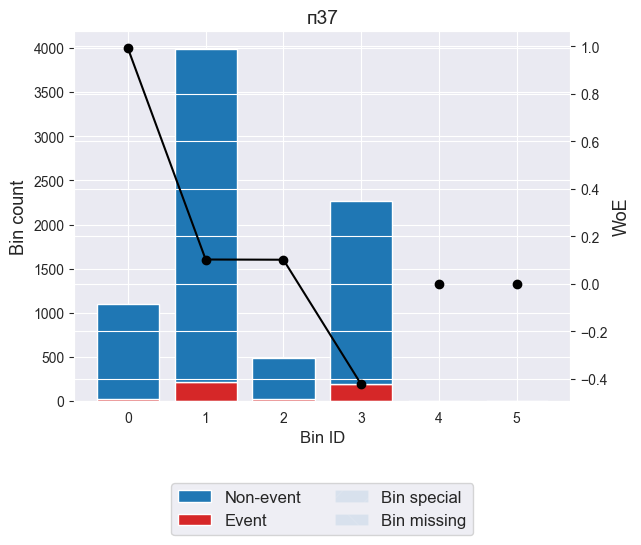

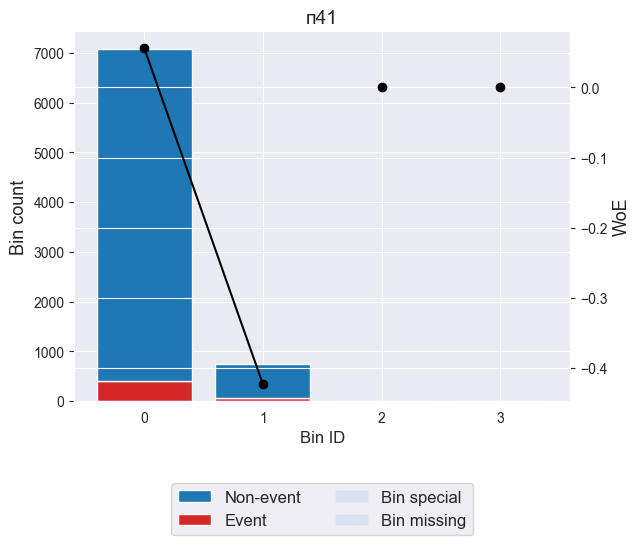

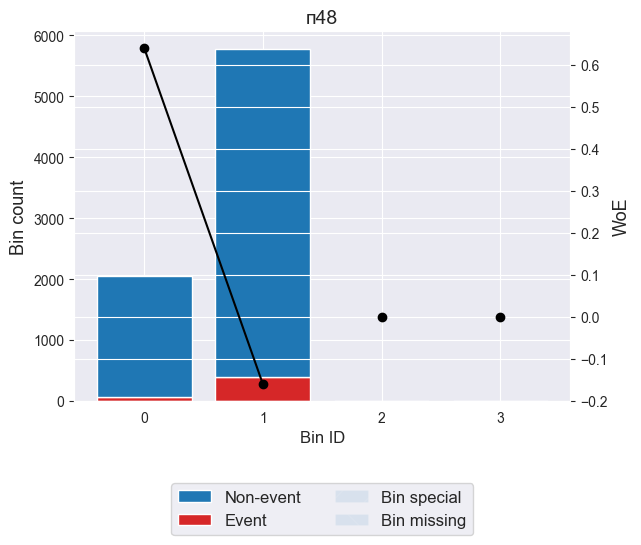

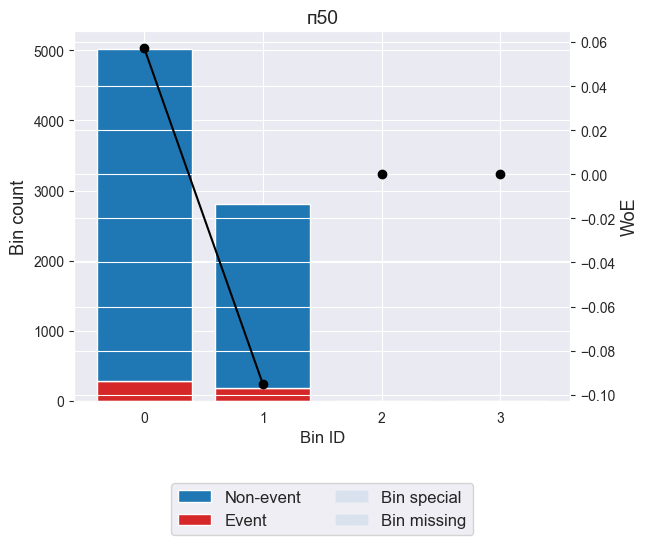

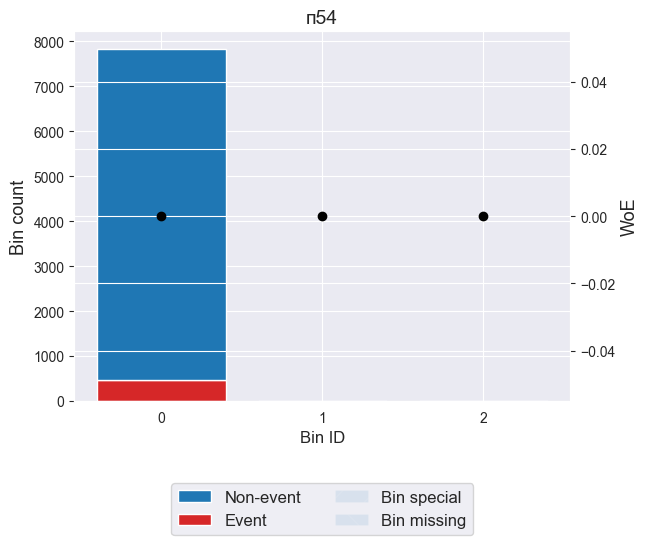

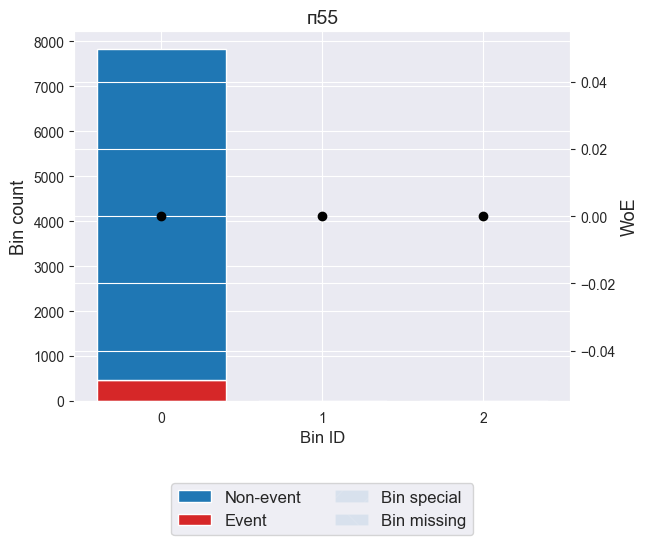

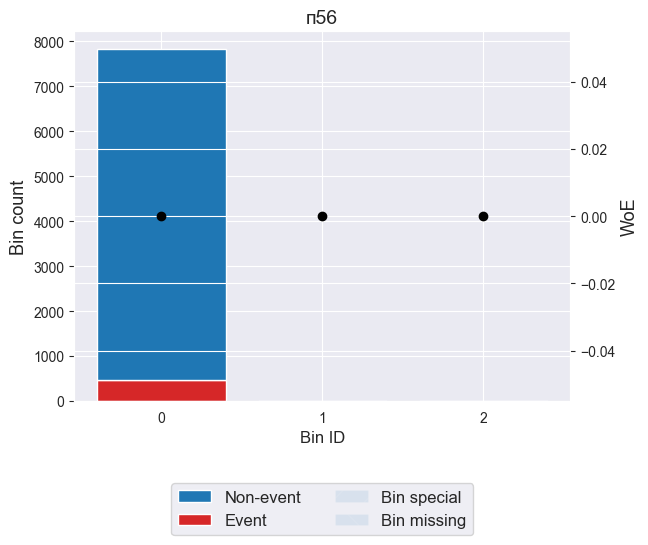

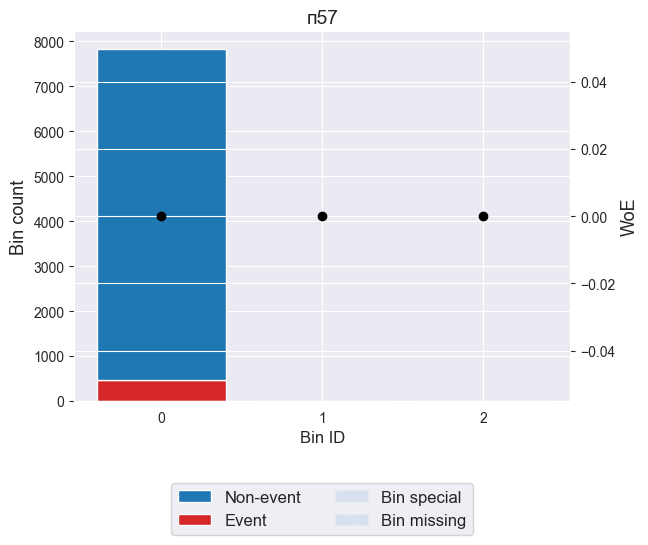

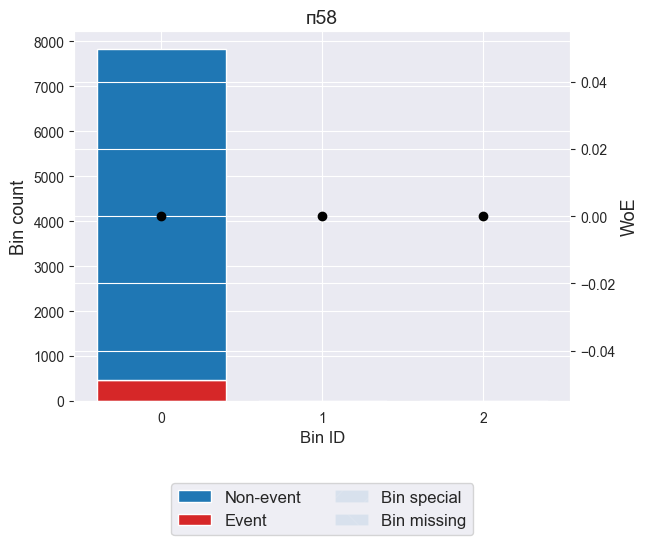

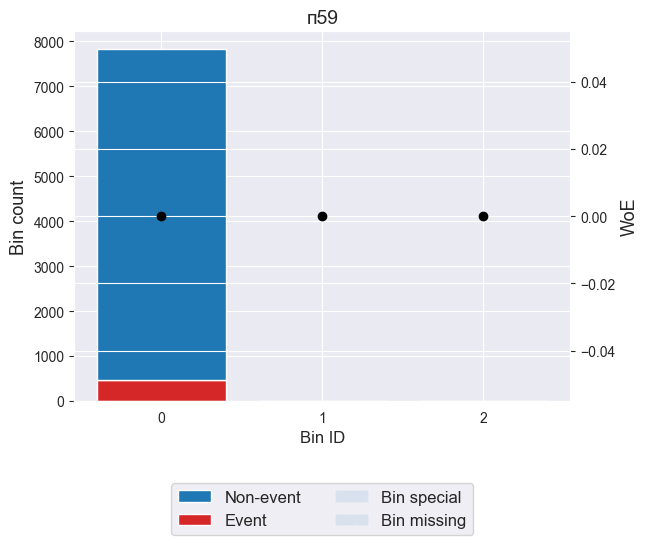

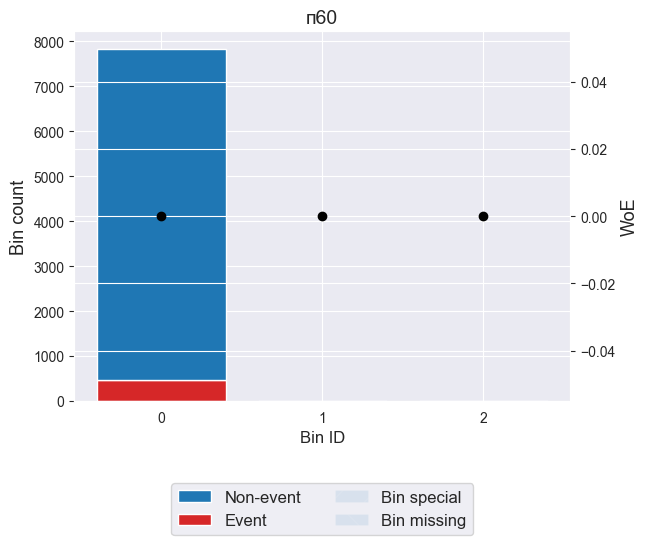

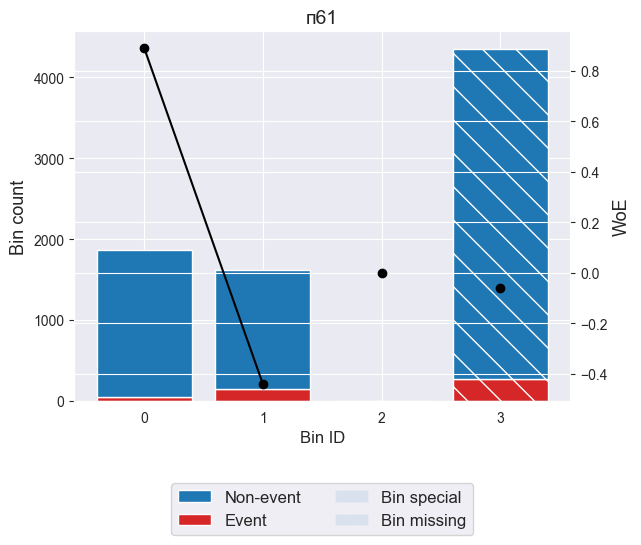

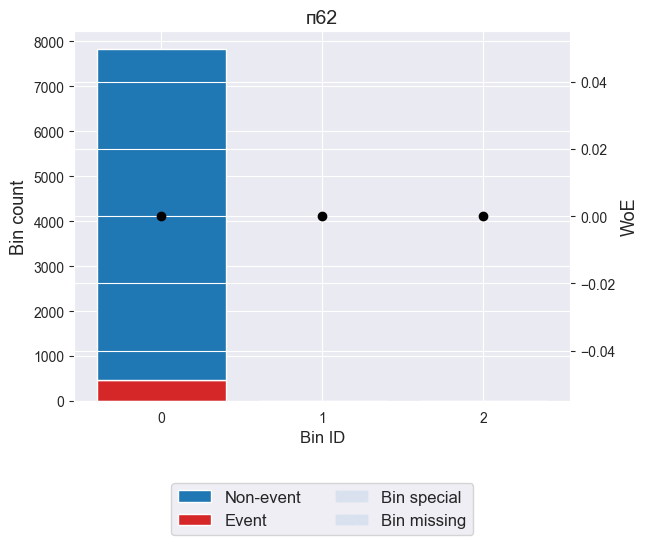

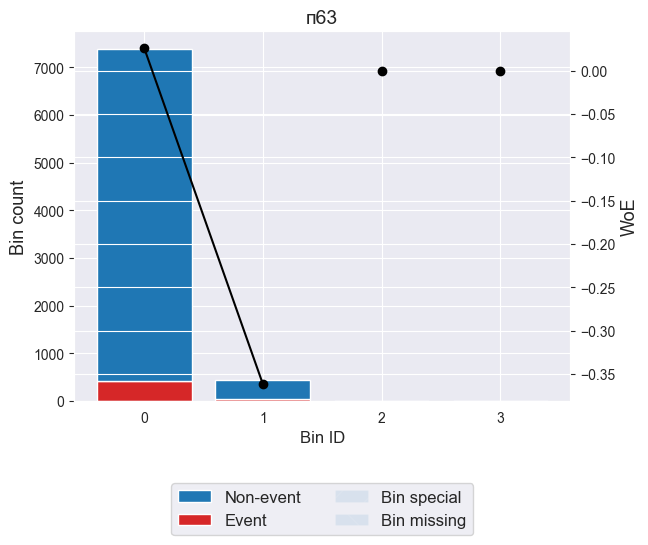

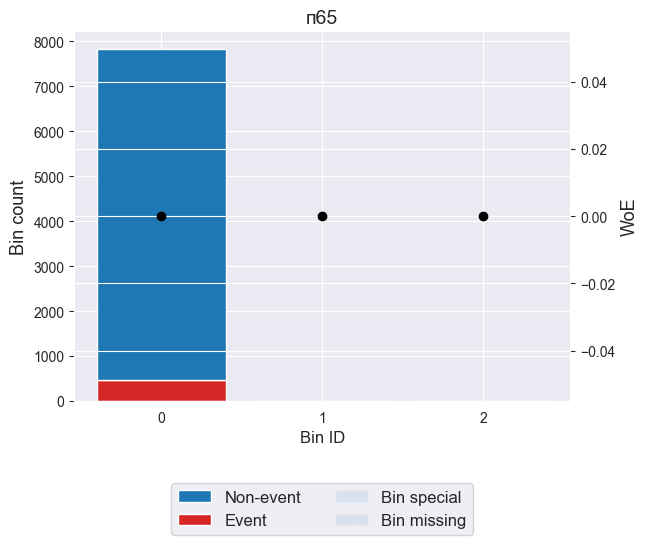

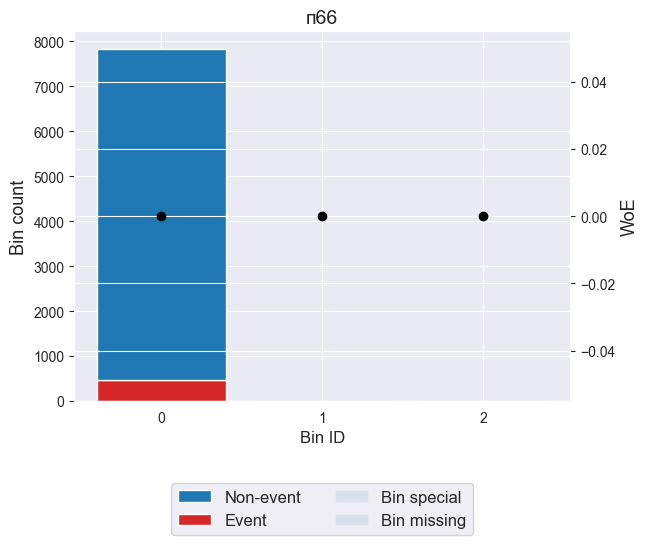

In [28]:
writer = pd.ExcelWriter(woe_category_file, engine='openpyxl')

for feature in categorical_features:
    optb = optbinning.OptimalBinning(name=feature, dtype='categorical',
                                     min_bin_size=min_bin_size)
    optb.fit(df_train[feature], df_train['def'])
    df_train_woe[feature] = optb.transform(df_train[feature], metric_missing='empirical')
    df_test_woe[feature] = optb.transform(df_test[feature], metric_missing='empirical')
    woe_dict[feature] = optb.binning_table.build()
    iv_dict[feature] = woe_dict.get(feature).loc['Totals', 'IV']
    optb.binning_table.plot(metric="woe")

    optb.binning_table.build().to_excel(writer, sheet_name=feature)

writer.close()

In [29]:
df_train_woe.head()

,def,п1,п2,п3,п5,п6,п9,п10,п12,п13,...,п57,п58,п59,п60,п61,п62,п63,п65,п66,п67
6081,0,0.671763,0.878797,-1.110223e-16,-0.300442,-0.331526,0.011178,-0.043718,-0.314939,-0.047818,...,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,0.888720,-1.110223e-16,0.026033,-1.110223e-16,-1.110223e-16,-0.288144
2908,0,0.528662,0.878797,-1.110223e-16,0.463630,0.379984,0.136766,-0.043718,-0.314939,0.451701,...,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-0.441931,-1.110223e-16,-0.361935,-1.110223e-16,-1.110223e-16,-0.011170
7210,0,0.671763,-0.186884,-1.110223e-16,-0.010334,0.240098,0.328480,0.070501,0.018634,-0.047818,...,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-0.060105,-1.110223e-16,0.026033,-1.110223e-16,-1.110223e-16,-0.288144
5719,1,0.671763,0.878797,-1.110223e-16,-0.010334,-0.195558,0.328480,-0.043718,0.102035,-0.047818,...,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,0.888720,-1.110223e-16,0.026033,-1.110223e-16,-1.110223e-16,-0.011170
493,0,0.528662,0.878797,-1.110223e-16,-0.300442,-0.331526,0.328480,-0.043718,0.018634,-0.047818,...,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,0.888720,-1.110223e-16,0.026033,-1.110223e-16,-1.110223e-16,-0.011170


In [30]:
iv_dict = dict(sorted(iv_dict.items(), key=operator.itemgetter(1), reverse=True))
iv_dict

{'п34': 0.7038228056442929,
 'п46': 0.34446677522800584,
 'п1': 0.3052873318829154,
 'п40': 0.26797578165545816,
 'п31': 0.22847242869946055,
 'п38': 0.20975571162731954,
 'п36': 0.2012638742411943,
 'п61': 0.1803469943378427,
 'п19': 0.17925114477643317,
 'п2': 0.16203911692831552,
 'п29': 0.161700299409507,
 'п37': 0.1590421802933673,
 'п6': 0.15835583957226546,
 'п67': 0.1492330048066665,
 'п16': 0.1443502773986767,
 'п22': 0.1421630289337431,
 'п5': 0.12554119449681034,
 'п48': 0.10223979317912377,
 'п21': 0.10213969694566882,
 'п27': 0.09863986856620387,
 'п15': 0.08342333548405924,
 'п14': 0.05992978325320611,
 'п39': 0.057839569298927404,
 'п35': 0.04098689568086311,
 'п9': 0.03931919217148846,
 'п42': 0.02608514244194418,
 'п41': 0.023543615133776244,
 'п13': 0.021560658418708575,
 'п12': 0.016140578577254212,
 'п17': 0.010454878917203089,
 'п63': 0.009415059097153846,
 'п33': 0.006083619718397759,
 'п50': 0.0054495462474426215,
 'п10': 0.0030813977807060055,
 'п28': 0.00256349

Получилось достаточно много переменных с высоким iv. Решила убрать все меньше 10%. Также вычистила корреляцию по принципу оставить самые важные переменные.

<span style="color:#008B8B">Можно было вычищать корреляцию по принципу оставить как можно больше переменных. Или не чистить совсем, а при построении модели не добавлять коррелирующие признаки (такой алгоритм будет описан ниже).</span>

In [31]:
iv_less_10 = []
for feature in iv_dict.keys():
    if iv_dict[feature] < 0.1:
        iv_less_10.append(feature)
iv_less_10

['п27',
 'п15',
 'п14',
 'п39',
 'п35',
 'п9',
 'п42',
 'п41',
 'п13',
 'п12',
 'п17',
 'п63',
 'п33',
 'п50',
 'п10',
 'п28',
 'п18',
 'п3',
 'п20',
 'п24',
 'п25',
 'п26',
 'п54',
 'п55',
 'п56',
 'п57',
 'п58',
 'п59',
 'п60',
 'п62',
 'п65',
 'п66']

In [32]:
for feature in iv_less_10:
    iv_dict.pop(feature)
    woe_dict.pop(feature)

df_train_woe =df_train_woe.drop(iv_less_10, axis=1)
df_test_woe = df_test_woe.drop(iv_less_10, axis=1)

In [33]:
corr = df_train_woe.corr().drop('def', axis=1)
for i in iv_dict.keys():
    print(i)
    print(corr.loc[(corr[i]>0.4) & (corr[i] < 1), i])
    print(i + " - " + str(iv_dict[i]))
    for j in corr.loc[(corr[i]>0.4) & (corr[i] < 1), i].index:
        print(j + " - " + str(iv_dict[j]))
    print()

п34
Series([], Name: п34, dtype: float64)
п34 - 0.7038228056442929

п46
п48    0.552411
Name: п46, dtype: float64
п46 - 0.34446677522800584
п48 - 0.10223979317912377

п1
п2     0.506289
п61    0.547683
Name: п1, dtype: float64
п1 - 0.3052873318829154
п2 - 0.16203911692831552
п61 - 0.1803469943378427

п40
п5     0.484294
п6     0.509212
п29    0.794898
п31    0.835427
п36    0.884458
п38    0.536869
Name: п40, dtype: float64
п40 - 0.26797578165545816
п5 - 0.12554119449681034
п6 - 0.15835583957226546
п29 - 0.161700299409507
п31 - 0.22847242869946055
п36 - 0.2012638742411943
п38 - 0.20975571162731954

п31
п5     0.529732
п6     0.578438
п29    0.870003
п36    0.792387
п38    0.438484
п40    0.835427
Name: п31, dtype: float64
п31 - 0.22847242869946055
п5 - 0.12554119449681034
п6 - 0.15835583957226546
п29 - 0.161700299409507
п36 - 0.2012638742411943
п38 - 0.20975571162731954
п40 - 0.26797578165545816

п38
п29    0.419260
п31    0.438484
п36    0.476583
п40    0.536869
Name: п38, dtype: floa

In [34]:
correlation_list = ['п48', 'п2', 'п61', 'п5', 'п6', 'п29', 'п31', 'п36', 'п38', 'п21', 'п22']
for feature in correlation_list:
    if feature in df_train_woe.columns:
        df_train_woe = df_train_woe.drop(feature, axis=1)
        df_test_woe = df_test_woe.drop(feature, axis=1)

        iv_dict.pop(feature)
        woe_dict.pop(feature)

In [35]:
iv_dict

{'п34': 0.7038228056442929,
 'п46': 0.34446677522800584,
 'п1': 0.3052873318829154,
 'п40': 0.26797578165545816,
 'п19': 0.17925114477643317,
 'п37': 0.1590421802933673,
 'п67': 0.1492330048066665,
 'п16': 0.1443502773986767}

In [36]:
models_columns = ['model', 'ROC-AUC best cross-val',
                  'gini train', 'ROC-AUC train',
                  'gini test', 'ROC-AUC']
models = pd.DataFrame(columns=models_columns)

In [37]:
features_train = df_train_woe.drop('def', axis=1)
features_test = df_test_woe.drop('def', axis=1)
target_train = df_train_woe['def']
target_test = df_test_woe['def']

### log-reg

Теперь построим модель лог-рег на оставшихся лучших параметрах.
Так как будем строить и подбирать лучшие параметры через сетку, то валидационная выборка не нужна. Сетка сама себя провалидирует.
Выведем итог моделей на тренировочной и тестовой выборках.

In [38]:
linear_parametrs = {"C":[1, 0.1, 0.01, 0.001],
                    "penalty":['l1', 'l2']}

clf = LogisticRegression(random_state=random_state)

grid = GridSearchCV(clf, linear_parametrs, cv=3, scoring='roc_auc')
grid.fit(features_train, target_train)

models = pd.concat([models, pd.DataFrame([['with_nb',
                                  grid.best_score_,
                                  2*grid.score(features_train, target_train)-1,
                                  grid.score(features_train, target_train),
                                  2*grid.score(features_test, target_test)-1,
                                  grid.score(features_test, target_test)]], columns=models_columns)], ignore_index=True)

print(grid.best_params_)

{'C': 0.01, 'penalty': 'l2'}


In [39]:
models

,model,ROC-AUC best cross-val,gini train,ROC-AUC train,gini test,ROC-AUC
0,with_nb,0.79193,0.591051,0.795525,0.513582,0.756791


<span style="color:#008B8B">Альтернативный алгоритм построения модели - последовательное добавление переменных в модель:
* следить за увеличением качества на тренировочной и валидационной выборкой
* следить за пороговым значением корреляции в модели
* следить за VIF - уровнем мультиколлинеарностью в модели
* следить за BIC - штрафом за сложность модели</span>

In [40]:
log_reg_with_nb = LogisticRegression(C=0.01, penalty='l2', random_state=random_state)
log_reg_with_nb.fit(features_train, target_train)

LogisticRegression(C=0.01, random_state=357)

In [41]:
# ks-статистика
sort_train_def_with_nb = log_reg_with_nb.predict_proba(features_train[df_train_woe['def'] == 1])[:, 1]
sort_train_non_def_with_nb = log_reg_with_nb.predict_proba(features_train[df_train_woe['def'] == 0])[:, 1]

sort_test_def_with_nb = log_reg_with_nb.predict_proba(features_test[df_test_woe['def'] == 1])[:, 1]
sort_test_non_def_with_nb = log_reg_with_nb.predict_proba(features_test[df_test_woe['def'] == 0])[:, 1]

print("with nb train:", stats.ks_2samp(sort_train_def_with_nb, sort_train_non_def_with_nb))
print("with nb test:", stats.ks_2samp(sort_test_def_with_nb, sort_test_non_def_with_nb))

with nb train: KstestResult(statistic=0.46266266125420064, pvalue=1.2788676656671879e-85, statistic_location=0.06628979835663382, statistic_sign=-1)
with nb test: KstestResult(statistic=0.39227439227439226, pvalue=1.4456377047978012e-20, statistic_location=0.06353404079984967, statistic_sign=-1)


In [42]:
log_reg_with_nb.coef_

array([[-0.37122647, -0.22828932, -0.2620764 , -0.61363509, -0.19374461,
        -0.3635847 , -0.36196707, -0.22485834]])

In [43]:
df_train[iv_dict.keys()].head()

,п34,п46,п1,п40,п19,п37,п67,п16
6081,381.0,NaN,Массовый сегмент,1572.03,с,ду,13.0,9
2908,298.2,492.0,Престиж,2029.00,сс,дз,60.0,23
7210,200.0,NaN,Массовый сегмент,1140.68,сс,дф,11.0,23
5719,142.0,NaN,Массовый сегмент,675.03,с,ду,36.0,0
493,255.0,NaN,Престиж,589.43,с,дз,42.0,0


In [44]:
writer = pd.ExcelWriter(output_result_file, engine='openpyxl')
corrMatrix = df_train_woe[iv_dict.keys()].corr()
corrMatrix.to_excel(writer, sheet_name='corrMatrix')

iv_df = pd.DataFrame(data=iv_dict, index=[0]).T
iv_df.to_excel(writer, sheet_name='iv')

train_pred_df = pd.DataFrame(data=df_train_woe['def'], columns=['def'])
train_pred_df['score'] = log_reg_with_nb.predict_proba(features_train)[:, 1]

train_pred_df.to_excel(writer, sheet_name='with_nb_pred')

writer.close()

Таким образом построено скоринговая модель.
Качество модели roc-auc с нацбанком train-test: 0.795-0.756

Скоринговые карты уже не строила для каждой модели по отдельности (по запросу могу построить).
Используемые параметры для построения карт:
* method = pdo_odds
* pdo = 75
* odds = 25
* scorecard_points = 1500

Подробные графики и предсказания модели находятся в excel файле.
На графиках видно, что при пороге отсечения pd = 12.27% в выборке с нацбанком остается 89.16% всех заявок и 3.64% дефолтов от всех заявок, а при пороге отсечения pd = 9.6% в выборке без нацбанка остается 86.09% всех заявок и 3.69% дефолтов от всех заявок.

### Доп анализ моделей

Посчитаем Accuracy, Precision, Recall и f1-меру для моделей. Порог отсечения поставим такой, чтобы после отсечения в выборке осталось 3.5% дефолтов от всех изначальных анкет выборки. Я бы выбрала более жестки порог.

Также выведем матрицу ошибок.

In [45]:
train_pred_df = train_pred_df.sort_values(by='score', ascending=False)

In [46]:
for i in range(len(train_pred_df)):
    if train_pred_df['def'].values[0:i].sum()/train_pred_df['def'].sum() > 0.41:
        print("3.5% дефолтов всей выборки остается при отсечении вероятности большей", train_pred_df['score'].values[i])
        break

3.5% дефолтов всей выборки остается при отсечении вероятности большей 0.11693340165889128


In [47]:
test_pred_df = pd.DataFrame(data=df_test_woe['def'], columns=['def'])
test_pred_df['score'] = log_reg_with_nb.predict_proba(features_test)[:, 1]

In [48]:
train_pred_df['class'] = np.where(train_pred_df['score'] > 0.1169, 1, 0)

test_pred_df['class'] = np.where(test_pred_df['score'] > 0.1169, 1, 0)

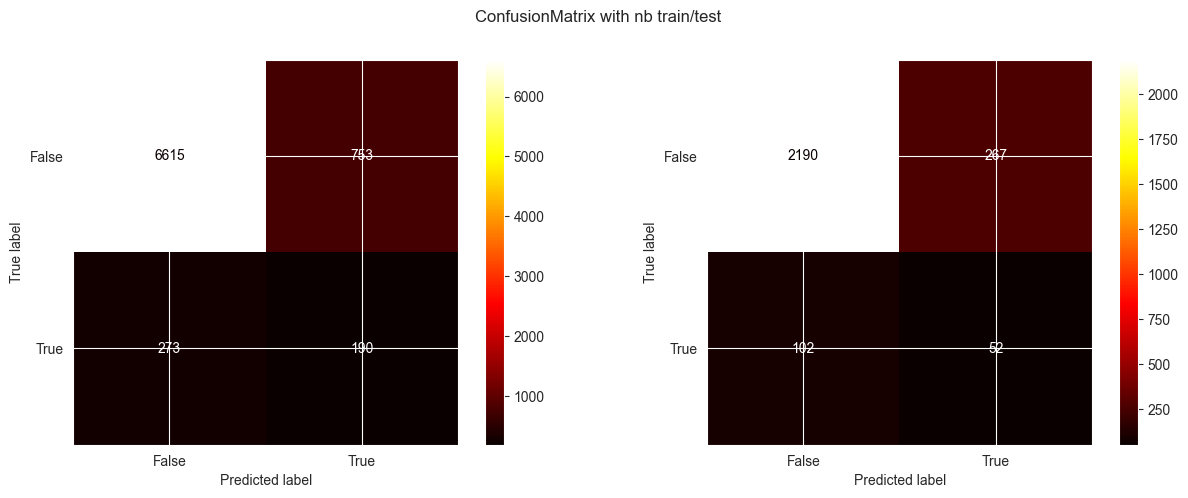

In [49]:
actual_train = train_pred_df['def']
predicted_train = train_pred_df['class']

actual_test = test_pred_df['def']
predicted_test = test_pred_df['class']

confusion_matrix_train = metrics.confusion_matrix(actual_train, predicted_train)
confusion_matrix_test = metrics.confusion_matrix(actual_test, predicted_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('ConfusionMatrix with nb train/test')

cm_display_train = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train, display_labels = [False, True])
cm_display_test = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test, display_labels = [False, True])


cm_display_train.plot(cmap=plt.get_cmap('hot'), ax=ax1)
cm_display_test.plot(cmap=plt.get_cmap('hot'), ax=ax2)

plt.show()

In [50]:
print('Accuracy train: %.3f' % accuracy_score(train_pred_df['def'], train_pred_df['class']))
print('Accuracy test: %.3f' % accuracy_score(test_pred_df['def'], test_pred_df['class']))
print()
print('Precision train: %.3f' % precision_score(train_pred_df['def'], train_pred_df['class']))
print('Precision test: %.3f' % precision_score(test_pred_df['def'], test_pred_df['class']))
print()
print('Recall train: %.3f' % recall_score(train_pred_df['def'], train_pred_df['class']))
print('Recall test: %.3f' % recall_score(test_pred_df['def'], test_pred_df['class']))
print()
print('F1 train: %.3f' % f1_score(train_pred_df['def'], train_pred_df['class']))
print('F1 test: %.3f' % f1_score(test_pred_df['def'], test_pred_df['class']))

Accuracy train: 0.869
Accuracy test: 0.859

Precision train: 0.201
Precision test: 0.163

Recall train: 0.410
Recall test: 0.338

F1 train: 0.270
F1 test: 0.220
